# EEG data examples

Here, we demonstrate `sbijax` using a complicated real world EEG data set.

In [3]:
import arviz as az
import jax
import numpy as np
import optax
import sbijax
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.ticker import AutoLocator, MaxNLocator
from jax import numpy as jnp, random as jr
from jax._src.flatten_util import ravel_pytree
from tensorflow_probability.substrates.jax import distributions as tfd

import matplotlib.pyplot as plt
import numpy as np

In [4]:
import mne
import moabb

from diffrax import ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, diffeqsolve
from scipy.signal import welch, periodogram
from moabb.datasets import Rodrigues2017

In [58]:
def sub(idx):
    subject = dataset.subject_list[idx]
    raw = dataset._get_single_subject_data(subject)
    raw = raw.filter(3, 40, verbose=False)
    raw = raw.resample(sfreq=128, verbose=False)

    events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
    event_id = {'closed': 1, 'open': 2}
    epochs = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=8.0, baseline=None, verbose=False)
    epochs = epochs.load_data().pick_channels(['Oz'])
    
    # estimate the averaged spectra for each condition
    X_closed = epochs['closed'].get_data()    
    X_opened = epochs['open'].get_data()
    f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], nperseg=2*32, axis=2)    
    f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], nperseg=2*32, axis=2)
    
    # plot the results
    fig = plt.figure(facecolor='white', figsize=(8, 6))
    for i in range(5):        
       plt.plot(f, np.log(S_closed[i, 0]), c='k', lw=1.0, label='closed')
       plt.plot(f, np.log(S_opened[i, 0]), c='r', lw=1.0, label='open')
    plt.xlabel('frequency', fontsize=14)
    plt.title('PSD on both conditions (averaged over 5 trials)', fontsize=16)    
    plt.legend()
    plt.show()

    _, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 10))
    for i in range(5):
        axes[i, 1].plot(X_opened[i, 0, :], color="red", label="opened", linewidth=.31)
        axes[i, 0].plot(X_closed[i, 0, :], color="black", label="closed", linewidth=.31)
    plt.legend()
    plt.show()


for i in [1]:
   print(i)
   sub(i)

1


NameError: name 'dataset' is not defined

## EEG data

In [4]:
import tempfile
temp_dir = tempfile.TemporaryDirectory()

In [8]:
dataset = Rodrigues2017()
dataset.download(path=temp_dir.name, verbose=False)

In [18]:
raw = dataset._get_single_subject_data(subject=2)['0']['0']
raw = raw.filter(l_freq=3, h_freq=40, verbose=False)
raw = raw.resample(sfreq=128, verbose=False)

In [19]:
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=8.0, baseline=None, verbose=False)
epochs = epochs.load_data().pick_channels(['Oz'])

Using data from preloaded Raw for 10 events and 1025 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [20]:
X_closed = epochs['closed'].get_data().squeeze()
f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], nperseg=64, axis=1)
S_closed_db = 10 * np.log10(S_closed)
X_opened = epochs['open'].get_data().squeeze()
f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], nperseg=64, axis=1)
S_opened_db = 10 * np.log10(S_opened)

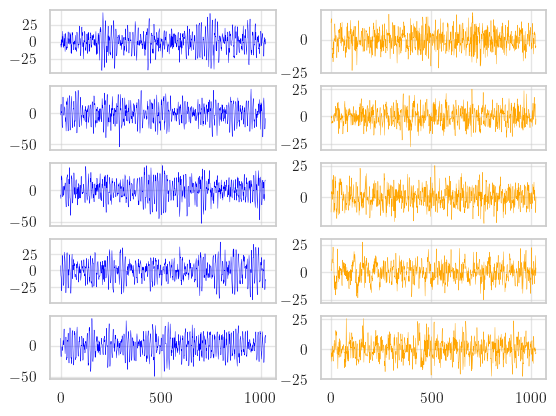

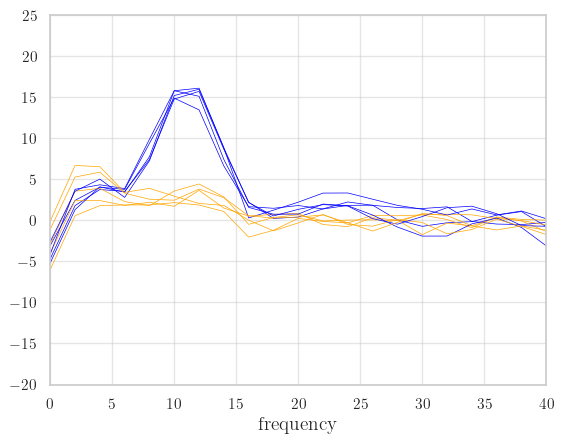

In [22]:
_, laxes = plt.subplots(nrows=5, ncols=2)
for i in range(5):
    laxes[i, 1].plot(X_opened[i, :], color="orange", label="opened", linewidth=.31)
    laxes[i, 0].plot(X_closed[i, :], color="blue", label="closed", linewidth=.31)
plt.show()

_, raxes = plt.subplots()
for i in range(5):
    raxes.plot(f, S_closed_db[i], color='blue', lw=.5)
    raxes.plot(f, S_opened_db[i], color='orange', lw=.5)
raxes.set_xlim(0, 40)
raxes.set_ylim(-20, +25)
raxes.set_xlabel('frequency', fontsize=14)
plt.show()

## Prior and simulator

In [59]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        C=tfd.Uniform(10.0, 250),
        mu=tfd.Uniform(50, 500),
        sigma=tfd.Uniform(50, 500),
        gain=tfd.Uniform(50, 500),
    ), batch_ndims=0)
    return prior

prior = prior_fn()

In [60]:
A = 3.25
B = 22.0
a = 100.0
b = 50.0
vmax = 5.0
v0 = 6.0
r = 0.56
sigma4 = 0.01
sigma6 = 1

In [61]:
def sigm(x, vmax=vmax, v0=v0, r=r):
    return vmax / (1 + jnp.exp(r * (v0 - x)))

In [20]:
def simulator(seed, theta, len_timeseries=10):   
    def diffusion(t, y, args):
        *_, sigma = args
        return jnp.vstack([jnp.eye(3), jnp.diag(jnp.array([sigma4, sigma, sigma6]))])
        
    def drift(t, y, args):
        C, gain, mu, sigma = args
        C1 = 1.00 * C
        C2 = 0.80 * C
        C3 = 0.25 * C
        C4 = 0.25 * C

        q, p = y[:3], y[3:]
        x1, x2, x3 = q

        gamma = jnp.diag(jnp.array([a, a, b]))
        G = jnp.array([
            A * a * sigm(x2 - x3),
            A * a * (mu + C2 * sigm(C1 * x1)),
            B * b * (C4 * sigm(C3 * x1)),
        ])

        return jnp.concatenate([p, G - gamma**2 @ q - 2 * gamma @ p])

    t0, t1 = 0.0, len_timeseries
    y0 = jnp.zeros(6)

    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(3,), key=seed)
    terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
    solver = Euler()
    saveat = SaveAt(ts=jnp.linspace(t0, t1, len_timeseries))

    # ravel_pytree maps in alphabetical order
    # C, gain, mu, sigma
    theta = jax.vmap(lambda x: ravel_pytree(x)[0])(theta)    
    locs = jnp.zeros((theta.shape[0], len_timeseries))
    for i in range(theta.shape[0]):
        sol = diffeqsolve(
            terms, solver, t0, t1, dt0=0.01, y0=y0, args=tuple(theta[i]), saveat=saveat
        )
        x = sol.ys[:, 1] - sol.ys[:, 2]
        x = jnp.power(10, theta[i, 1] / 10) * x
        locs = locs.at[i].set(x)
    return locs

In [22]:
theta = prior.sample(seed=jr.PRNGKey(123), sample_shape=(10,))

In [23]:
xxx = simulator(jr.PRNGKey(2), theta)
xxx

Array([[ 0.00000000e+00, -1.01353546e+24,  1.34071671e+24,
        -1.35105584e+23,  5.96536610e+23, -5.10384587e+23,
         3.08740417e+23, -8.66937668e+23, -1.56587997e+24,
        -1.07955246e+24],
       [            nan,            -inf,            -inf,
                   -inf,            -inf,            -inf,
                   -inf,            -inf,            -inf,
                   -inf],
       [ 0.00000000e+00,  1.93821581e+09,  3.87864806e+09,
         3.29283661e+09,  2.46264678e+09,  2.74811034e+09,
         2.74336358e+09,  2.38497050e+09,  2.74393088e+09,
         2.32037914e+09],
       [ 0.00000000e+00, -1.83262400e+08, -4.83666840e+07,
        -1.36672048e+08, -1.06688120e+07, -1.93205520e+08,
        -6.46211080e+07, -2.79016864e+08, -2.33324112e+08,
        -4.16322784e+08],
       [ 0.00000000e+00,  3.07233784e+11,  4.10929496e+11,
         3.27927923e+11,  2.94167478e+11,  3.52667730e+11,
         3.75568171e+11,  2.61396382e+11,  4.63315337e+11,
         2.

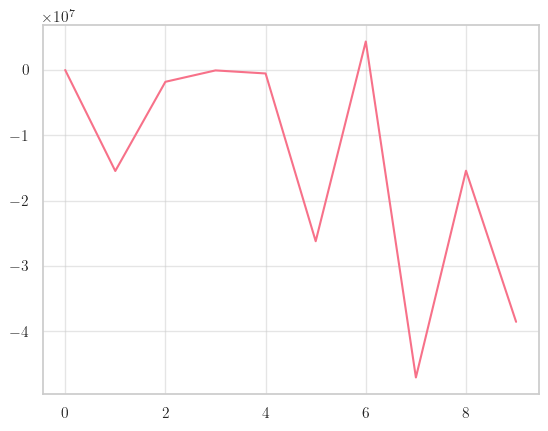

In [89]:
plt.plot(xxx[0])
plt.show()

In [130]:
theta

{'sigma': Array([427.3971  , 353.82385 ,  98.443054, 149.19249 ,  72.03113 ,
        263.2907  , 260.909   , 138.72946 , 199.98897 , 462.52155 ],      dtype=float32),
 'mu': Array([397.7737 , 119.24289, 423.57352, 313.9927 , 159.07428, 196.66872,
         92.81337, 274.45557, 477.9882 ,  97.09621], dtype=float32),
 'gain': Array([ 63.46689,  99.7031 ,  93.14253, 240.04936, 369.05283, 369.15448,
        392.1011 , 471.43286, 422.11542, 414.7781 ], dtype=float32),
 'C': Array([ 92.23762 , 213.97754 ,  28.89102 , 220.36249 ,  15.52166 ,
         30.186863,  19.374914,  53.28296 , 200.44803 , 202.90433 ],      dtype=float32)}

In [47]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        C=tfd.Uniform(10.0, 250),
        mu=tfd.Uniform(50, 500),
        sigma=tfd.Uniform(100, 500),
        gain=tfd.Uniform(-20, 20),
    ), batch_ndims=0)
    return prior

prior = prior_fn()

In [79]:
theta_ground_truth = np.array([135, 220, 2000, 0])

In [74]:
np.arange(25).reshape(5, 5)[::5]

array([[0, 1, 2, 3, 4]])

In [104]:
def jansen_rit_fn(len_timeseries=1024, t_end=8.0):
    import rpy2.robjects as robjects
    from rpy2.robjects.packages import importr   
    sdbmp = importr("sdbmsABC")

    rchol = robjects.r["chol"]
    rt = robjects.r["t"]
    
    A = 3.25
    B = 22.0
    a = 10.0
    b = 50.0
    vmax = 5.0
    v0 = 6.0
    r = 0.56
    sigma4 = 0.01
    sigma6 = 1.0
    
    burnin = 2.0
    h = 1 / len_timeseries
    grid = robjects.FloatVector(list(np.arange(0, t_end + burnin, h)))    

    def fn(seed, theta):        
        C, mu, sigma, gain = theta.tolist()
        gain_abs = 10 ** (gain / 10)
        y0 = robjects.FloatVector([0.08, 18, 15, -0.5, 0, 0])
        dm = sdbmp.exp_matJR(h, a, b)
        cm = rt(
            rchol(sdbmp.cov_matJR(h, robjects.FloatVector([0, 0, 0, sigma4, sigma, sigma6]), a, b))
        )
        yt = gain_abs * jnp.array(
            sdbmp.Splitting_JRNMM_output_Cpp(
                h, y0, grid, dm, cm, mu, C, A, B, a, b, v0, r, vmax
            )
        )
        yt = yt[int(burnin / h): ]
        yt = yt[::8]
        return yt

    return fn

In [105]:
jn = jansen_rit_fn()

In [106]:
xxx = jn(None, theta_ground_truth)

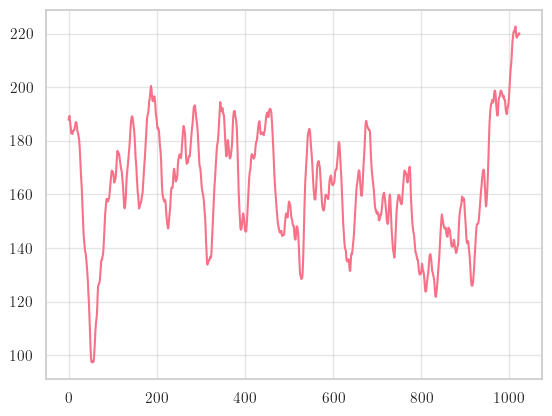

In [107]:
plt.plot(xxx)
plt.show()

In [46]:
def simulator(seed, theta):
    d

Array([[ 3.0000000e+00,  1.2052831e+11,  2.5226773e+20,  1.8714527e+29,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [ 3.0000000e+00,  1.4228043e+11,  2.9881510e+20,  2.2187227e+29,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [ 3.0000000e+00, -3.9436001e+10, -8.2140767e+19, -6.0717695e+28,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [ 3.0000000e+00,  1.4746062e+11,  3.0927499e+20,  2.2954932e+29,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [ 3.0000000e+00, -2.0406564e+11, -4.2505663e+20, -3.1453583e+29,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [ 3.0000000e+00,  1.8891181e+11,  3.9514386e+20,  2.9300221e+29,
   

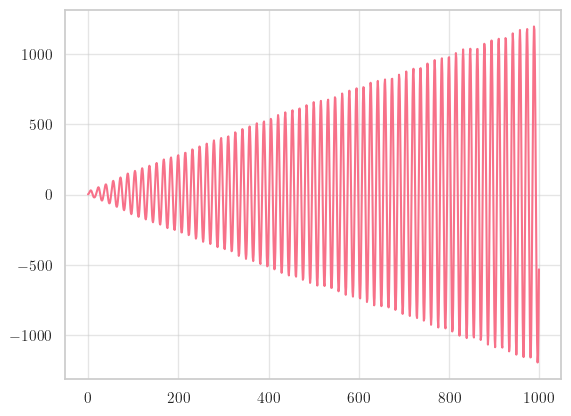

In [37]:
plt.plot(xxx[0])
plt.show()